In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

key = jax.random.PRNGKey(42)
tf.random.set_seed(42)

2022-08-02 19:04:03.749171: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset = 'mnist'
# dataset = 'fashion'
readout_mode = 'softmax'
# readout_mode = 'sample'
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

In [3]:
n = 8
n_node = 8

In [4]:
K = tc.set_backend('jax')

In [5]:
# numpy data
if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
elif dataset == 'fashion':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_train == 9
x_train, y_train = x_train[~ind], y_train[~ind]
ind = y_train == 8
x_train, y_train = x_train[~ind], y_train[~ind]

x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5
x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))
y_test = jax.nn.one_hot(y_test, n_node)

def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y

2022-08-02 19:04:09.633178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 19:04:12.090920: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-02 19:04:12.090991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30169 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:14:00.0, compute capability: 7.0


In [6]:
def clf(params, c, k):
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[3 * j, i])
            c.rz(i, theta=params[3 * j + 1, i])
            c.rx(i, theta=params[3 * j + 2, i])
    return c

def readout(c):
    if readout_mode == 'softmax':
        logits = []
        for i in range(n_node):
            logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
        logits = jnp.stack(logits, axis=-1) * 10
        probs = jax.nn.softmax(logits)
    elif readout_mode == 'sample':
        wf = jnp.abs(c.wavefunction()[:n_node])**2
        probs = wf / jnp.sum(wf)
    return probs

In [7]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return -jnp.mean(jnp.sum(y * jnp.log(probs + 1e-7), axis=-1))
loss = K.jit(loss, static_argnums=[3])

In [8]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [9]:
k = 48

In [10]:
compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, batch 0/100, loss 0.2736464738845825, accuracy 0.1142578125
Epoch 0, batch 25/100, loss 0.14593003690242767, accuracy 0.6689453125
Epoch 0, batch 50/100, loss 0.11302518844604492, accuracy 0.779296875
Epoch 0, batch 75/100, loss 0.1005469262599945, accuracy 0.8095703125
Epoch 1, batch 0/100, loss 0.09412410855293274, accuracy 0.826171875
Epoch 1, batch 25/100, loss 0.09116887301206589, accuracy 0.83203125
Epoch 1, batch 50/100, loss 0.08875268697738647, accuracy 0.845703125
Epoch 1, batch 75/100, loss 0.08927672356367111, accuracy 0.8330078125
Epoch 2, batch 0/100, loss 0.08850528299808502, accuracy 0.8310546875
Epoch 2, batch 25/100, loss 0.08429641276597977, accuracy 0.8505859375
Epoch 2, batch 50/100, loss 0.08221389353275299, accuracy 0.857421875
Epoch 2, batch 75/100, loss 0.08152715861797333, accuracy 0.8623046875
Epoch 3, batch 0/100, loss 0.08144066482782364, accuracy 0.8681640625
Epoch 3, batch 25/100, loss 0.0799330621957779, accuracy 0.8662109375
Epoch 3, batch 50/1

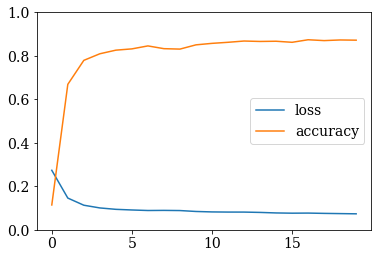

In [11]:
params_list = []
opt_state_list = []
data_list = []
iter_list = []
for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)
    data_list.append(data)
    iter_list.append(iter(data))

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)
    params_list.append(params)
    opt_state_list.append(opt_state)


loss_list = []
acc_list = []
for e in tqdm(range(5), leave=False):
    for b in range(100):
        for node in range(n_node-1):
            try:
                x, y = next(iter_list[node])
            except StopIteration:
                iter_list[node] = iter(data_list[node])
                x, y = next(iter_list[node])
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params_list[node], x, y, k)
            updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
            params_list[node] = optax.apply_updates(params_list[node], updates)
        
        avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
        for node in range(n_node-1):
            params_list[node] = avg_params
        
        if b % 25 == 0:
            avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
            loss_list.append(avg_loss)
            acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
            print(f"Epoch {e}, batch {b}/{100}, loss {avg_loss}, accuracy {acc_list[-1]}")


plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 1)
plt.show()


In [12]:
jnp.save(f'./{dataset}/fedavg_loss.npy', loss_list)
jnp.save(f'./{dataset}/fedavg_acc.npy', acc_list)

In [14]:
def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

In [15]:
jnp.mean(pred(avg_params, x_test[:1024], k).argmax(axis=-1) == y_test[:1024].argmax(axis=-1))

DeviceArray(0.6142578, dtype=float32)

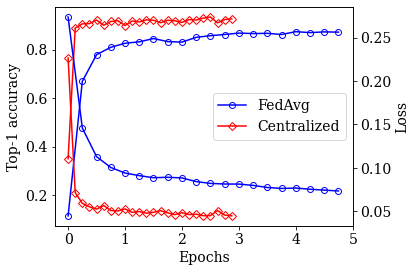

In [15]:
cent_loss = jnp.load(f'./{dataset}/central_loss.npy')
cent_acc = jnp.load(f'./{dataset}/central_acc.npy')
loss_list = jnp.load(f'./{dataset}/fedavg_loss.npy')
acc_list = jnp.load(f'./{dataset}/fedavg_acc.npy')

plt.plot(jnp.arange(len(acc_list))/4, acc_list, color='blue', label='FedAvg', marker='o', markerfacecolor='none')
plt.plot(jnp.arange(len(cent_acc))/8, cent_acc, color='red', label='Centralized', marker='D', markerfacecolor='none')
# plt.hlines(0.7490, 0, 5, color='black', linestyles='dashed')
# plt.ylim(0.3, 0.8)
plt.ylabel('Top-1 accuracy')
plt.xlabel('Epochs')
plt.twinx()

plt.plot(jnp.arange(len(loss_list))/4, loss_list, color='blue', label='FedAvg', marker='o', markerfacecolor='none')
plt.plot(jnp.arange(len(cent_loss))/8, cent_loss, color='red', label='Centralized', marker='D', markerfacecolor='none')
# plt.hlines(0.1909, 0, 5, color='black', linestyles='dashed')
# plt.ylim(0.1, 0.5)
plt.ylabel('Loss')

plt.xticks(jnp.arange(6))
plt.legend(loc='center right')
plt.tight_layout()
plt.savefig(f'./{dataset}/cent_fedavg.pdf')
plt.show()